In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import os
import torch
import numpy as np 
import pandas as pd 
from glob import glob
from tqdm import tqdm
import supervision as sv
import matplotlib.pyplot as plt
from groundingdino.util.inference import Model
from segment_anything import sam_model_registry, SamPredictor

In [3]:
new_images = glob("../data/dataset/New_dataset/Images/*.jpg")
new_masks = [i.replace("Images" , "Masks") for i in new_images]
new_masks = [j.replace("jpg","tif") for j in new_masks]

split_idx = int(len(new_images) * 0.8)

train_images, train_masks = new_images[:split_idx], new_masks[:split_idx]
val_images, val_masks = new_images[split_idx:], new_masks[split_idx:]

len(train_images), len(train_masks), len(val_images), len(val_masks)

(212, 212, 54, 54)

In [4]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class NewImageDataset(Dataset):
    def __init__(self, images, masks, augment_factor=1, transform=False, building_threshold=0.1):
        self.images = images
        self.masks = masks
        self.augment_factor = augment_factor
        self.transform = transform
        self.to_tensor = transforms.ToTensor()
        self.building_threshold = building_threshold
        
        # Filter images based on the building area threshold
        self.valid_indices = self._filter_images()

    def _filter_images(self):
        valid_indices = []
        for idx, (image_path, mask_path) in enumerate(zip(self.images, self.masks)):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            building_area = (mask > 0).sum() / (mask.size)  # Normalized by total number of pixels

            if building_area >= self.building_threshold:
                valid_indices.append(idx)

        return valid_indices

    def __len__(self):
        # Each valid image generates patches according to augment factor
        return len(self.valid_indices) * 16 * self.augment_factor

    def __getitem__(self, idx):
        # Determine the image and augmentation index based on valid images
        effective_index = (idx // self.augment_factor) % (len(self.valid_indices) * 16)  # Ensure we stay within bounds
        image_idx = self.valid_indices[effective_index // 16]  # Get the index of the valid image

        # Load the 1024x1024 image and mask
        image_path = self.images[image_idx]
        mask_path = self.masks[image_idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Patching process for 256x256 patches
        patch_idx = effective_index % 16  # Get the patch index
        x_offset = (patch_idx % 4) * 256
        y_offset = (patch_idx // 4) * 256
        image_patch = image[y_offset:y_offset + 256, x_offset:x_offset + 256]
        mask_patch = mask[y_offset:y_offset + 256, x_offset:x_offset + 256]

        # Convert to tensors and normalize
        image_patch = self.to_tensor(image_patch)
        mask_patch = torch.from_numpy(mask_patch).float() / 255.0
        mask_patch = mask_patch.unsqueeze(0)  # Add channel dimension for mask

        # Apply augmentation if required
        if self.transform:
            image_patch, mask_patch = augment_image_with_mask(image_patch, mask_patch)

        return image_patch, mask_patch

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_augmentation(image, mask):
    # Convert tensors back to numpy for visualization
    image_np = image.permute(1, 2, 0).numpy()  # HWC format
    mask_np = mask.squeeze(0).numpy()  # Remove channel dimension for grayscale

    # Create a red mask (3 channels)
    red_mask = np.zeros_like(image_np)  # Create an empty array with the same shape as the image
    red_mask[..., 0] = mask_np * 255  # Set red channel to mask values (255 for positive areas)

    # Use cv2.addWeighted for overlay
    overlay = cv2.addWeighted(image_np, 0.6, red_mask / 255.0, 0.4, 0)  # Blend with the original image

    # Display image and mask side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(image_np)
    axs[0].set_title('Image')
    axs[0].axis('off')
    
    axs[1].imshow(overlay)  # Show the overlay image
    axs[1].set_title('Overlayed Mask (in Red)')
    axs[1].axis('off')
    
    plt.show()

In [10]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image, ImageFilter
import random

def augment_image_with_mask(image, mask):
    # Seed for reproducibility to apply the same spatial transform on both image and mask
    seed = np.random.randint(2147483647)
    
    # Spatial transformations to apply to both image and mask
    spatial_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.2)),  # Randomly crop and resize
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
    ])
    
    # Color jitter and blur applied only to the image
    photometric_transforms = transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    ])

    # Apply spatial transformations to both image and mask
    torch.manual_seed(seed)
    image = spatial_transforms(image)
    torch.manual_seed(seed)
    mask = spatial_transforms(mask)

    # Apply color jitter only to the image
    # image = photometric_transforms(image)

    return image, mask

In [6]:
train_dataset  = NewImageDataset(train_images, train_masks, transform = True, augment_factor=2, building_threshold= 0.15)
len(train_dataset)

2400

In [7]:
val_dataset  = NewImageDataset(val_images, val_masks, transform = False, augment_factor=1, building_threshold= 0.15)
len(val_dataset)

592

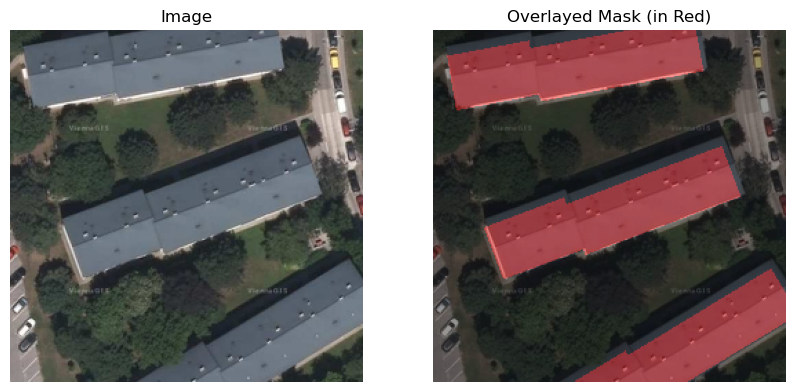

In [74]:
idx = 300
image, mask = val_dataset[idx]
visualize_augmentation(image,mask)

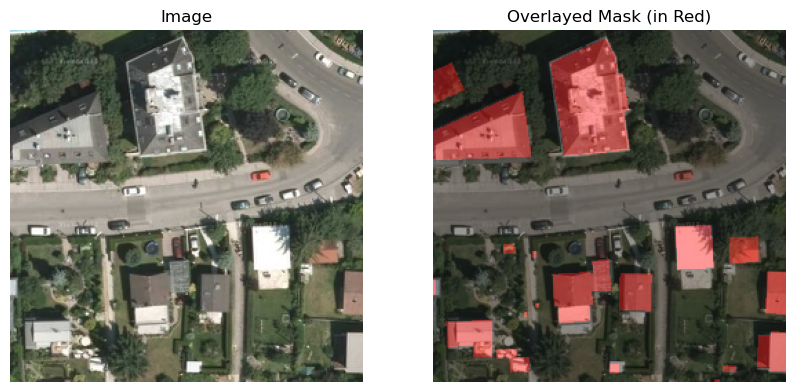

In [79]:
idx = 194
image, mask = val_dataset[idx]
visualize_augmentation(image,mask)

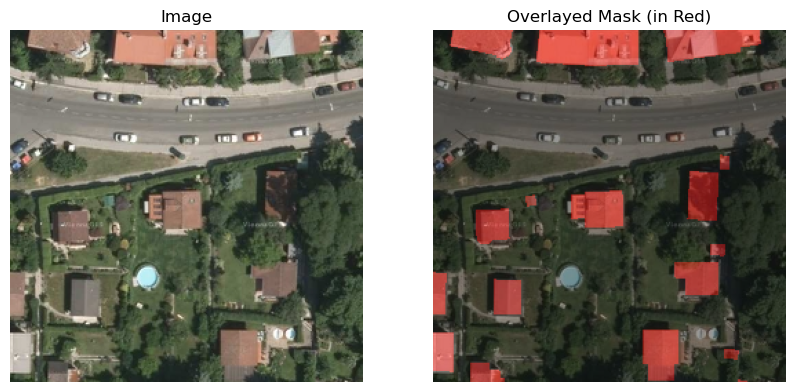

In [80]:
idx = 195
image, mask = val_dataset[idx]
visualize_augmentation(image,mask)

## Training

In [21]:
from torch.utils.data import DataLoader
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
import torch
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer,scheduler, device,threshold=0.2):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    total_iou = 0.0

    num_batches = len(dataloader)
    for images, masks in tqdm(dataloader):
        images = images.to(device)          # [batch_size, 3, 256, 256]
        masks = masks.to(device)            # [batch_size, 1, 256, 256]
        optimizer.zero_grad()
        outputs = model(images)             # Forward pass: [batch_size, 1, 256, 256]
        loss = criterion(outputs, masks)    # Compute loss
        loss.backward()                     # Backward pass
        optimizer.step()                    # Update weights
        running_loss += loss.item()         # Accumulate loss

       # Calculate IoU for the current batch
        preds = (torch.sigmoid(outputs) > threshold).float()  # Threshold the outputs
        intersection = (preds * masks).sum(dim = [1,2,3])
        union = preds.sum(dim = [1,2,3]) + masks.sum(dim = [1,2,3]) - intersection
        iou = (intersection / (union + 1e-6)).mean() # Add small value to avoid division by zero
        total_iou += iou.item()  # Accumulate IoU
        
        
    scheduler.step()
    avg_loss = running_loss / num_batches
    avg_iou = total_iou / num_batches
    return avg_loss, avg_iou 


# Validation function
def validate(model, dataloader, criterion, device,threshold = 0.2):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    total_iou = 0.0
    num_batches = len(dataloader)

    with torch.no_grad():  # Disable gradient computation
        for images, masks in tqdm(dataloader):
            images = images.to(device)      # [batch_size, 3, 256, 256]
            masks = masks.to(device)        # [batch_size, 1, 256, 256]
            batch_size = images.shape[0]
            outputs = model(images)         # Forward pass
            loss = criterion(outputs, masks)  # Compute validation loss
            running_loss += loss.item()     # Accumulate loss

            # Calculate IoU for the current batch
            preds = (torch.sigmoid(outputs) > threshold).float()  # Threshold the outputs
            intersection = (preds * masks).sum(dim = [1,2,3])
            union = preds.sum(dim = [1,2,3]) + masks.sum(dim = [1,2,3]) - intersection
            iou = (intersection / (union + 1e-6)).mean()  # Add small value to avoid division by zero
            total_iou += iou.item()  # Accumulate IoU
            
    avg_loss = running_loss / num_batches
    avg_iou = total_iou / num_batches
    return avg_loss, avg_iou

# Inference function
def infer(model, dataloader, out_dir , criterion ,device,threshold = 0.2):
    pred_list = []
    model.eval()  # Set the model to evaluation mode
    results_list = []  # To store image and loss pairs
    with torch.no_grad():  # Disable gradient computation
        for image, mask, image_id in tqdm(dataloader):
            output_path = out_dir+f'/{image_id[0]}'

            image = image.to(device)      # [batch_size, 3, 256, 256]
            mask = mask.to(device)        # [batch_size, 1, 256, 256]
            outputs = model(image)

            loss = criterion(outputs, mask).cpu().item()
            
            pred_mask = (torch.sigmoid(outputs) > threshold).float()  # Binary mask [1, 1, 256, 256]
            intersection = (pred_mask * mask).sum()
            union = pred_mask.sum() + mask.sum() - intersection
            iou = (intersection / (union + 1e-6)).cpu().numpy()  # Add small value to avoid division by zero

            pred_mask = pred_mask.squeeze(0).squeeze(0)
            binary_mask = pred_mask.cpu().numpy()  # Convert to numpy array
            binary_mask = (np.stack([binary_mask] * 3, axis=-1))          
            
            pred_list.append([image_id[0] ,iou,loss])
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
            # Save the predicted mask
            cv2.imwrite(output_path, binary_mask)
    return pred_list

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class UNetMobileNetV2(nn.Module):
    def __init__(self, num_classes=1, pretrained=True, dropout_rate=0):
        super(UNetMobileNetV2, self).__init__()

        # Load the pretrained MobileNetV2 as the encoder
        mobilenet_v2 = models.mobilenet_v2(pretrained=pretrained)

        # Extract feature layers from the MobileNetV2 encoder
        self.encoder = mobilenet_v2.features
        for param in self.encoder.parameters():
            param.requires_grad = True
        # Upsampling / Decoder part
        self.upconv1 = nn.ConvTranspose2d(1280, 320, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(320 + 96, 320, dropout_rate)

        self.upconv2 = nn.ConvTranspose2d(320, 192, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(192 + 32, 192, dropout_rate)

        self.upconv3 = nn.ConvTranspose2d(192, 64, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(64 + 24, 64, dropout_rate)

        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(32 + 16, 32, dropout_rate)

        self.upconv5 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.decoder5 = self.conv_block(16 + 3, 16, dropout_rate)  # Adding skip connection with input

        # Final 1x1 convolution to get the desired number of output channels
        self.final_conv = nn.Conv2d(16, num_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels, dropout_rate):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)  # Add dropout after each convolution block
        )

    def forward(self, x):
        # Encoder: Forward through MobileNetV2
        enc1 = self.encoder[0:2](x)    # [3, 256, 256] -> [16, 128, 128]
        enc2 = self.encoder[2:4](enc1) # [16, 128, 128] -> [24, 64, 64]
        enc3 = self.encoder[4:7](enc2) # [24, 64, 64] -> [32, 32, 32]
        enc4 = self.encoder[7:14](enc3) # [32, 32, 32] -> [96, 16, 16]
        enc5 = self.encoder[14:](enc4) # [96, 16, 16] -> [1280, 8, 8]

        # Decoder: Upsample and concatenate with corresponding encoder layers
        dec1 = self.upconv1(enc5)          # [1280, 8, 8] -> [320, 16, 16]
        dec1 = torch.cat([dec1, enc4], dim=1)  # Concatenate with enc4
        dec1 = self.decoder1(dec1)         # [320 + 96, 16, 16] -> [320, 16, 16]

        dec2 = self.upconv2(dec1)          # [320, 16, 16] -> [192, 32, 32]
        dec2 = torch.cat([dec2, enc3], dim=1)  # Concatenate with enc3
        dec2 = self.decoder2(dec2)         # [192 + 32, 32, 32] -> [192, 32, 32]

        dec3 = self.upconv3(dec2)          # [192, 32, 32] -> [64, 64, 64]
        dec3 = torch.cat([dec3, enc2], dim=1)  # Concatenate with enc2
        dec3 = self.decoder3(dec3)         # [64 + 24, 64, 64] -> [64, 64, 64]

        dec4 = self.upconv4(dec3)          # [64, 64, 64] -> [32, 128, 128]
        dec4 = torch.cat([dec4, enc1], dim=1)  # Concatenate with enc1
        dec4 = self.decoder4(dec4)         # [32 + 16, 128, 128] -> [32, 128, 128]

        dec5 = self.upconv5(dec4)          # [32, 128, 128] -> [16, 256, 256]
        dec5 = torch.cat([dec5, x], dim=1)     # Concatenate with input image
        dec5 = self.decoder5(dec5)         # [16 + 3, 256, 256] -> [16, 256, 256]

        # Final output
        out = self.final_conv(dec5)        # [16, 256, 256] -> [1, 256, 256] (binary output)
        return out

In [24]:
model = UNetMobileNetV2().to(device)

In [29]:
import torch
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torchvision import transforms

batch_size = 32
lr = 0.001
dropout_rate = 0

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [30]:
train_losses = []
val_losses = []
train_ious = []
val_ious = []

In [31]:
num_epochs = 40
for epoch in range(num_epochs):
    train_loss, train_iou = train(model, train_loader, criterion, optimizer,scheduler, device,threshold=0.5)
    val_loss, val_iou = validate(model, val_loader, criterion, device , threshold=0.5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.8f}, Train IoU: {train_iou:.8f}, '
          f'Val Loss: {val_loss:.8f}, Val IoU: {val_iou:.8f}')

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:12<00:00,  1.58it/s]


Epoch [1/40], Train Loss: 0.40401351, Train IoU: 0.48856363, Val Loss: 0.44487950, Val IoU: 0.41384158


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.58it/s]


Epoch [2/40], Train Loss: 0.28617994, Train IoU: 0.58320494, Val Loss: 0.43435040, Val IoU: 0.48563473


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.64it/s]


Epoch [3/40], Train Loss: 0.24719641, Train IoU: 0.59933750, Val Loss: 0.36047502, Val IoU: 0.53078174


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.64it/s]


Epoch [4/40], Train Loss: 0.22357493, Train IoU: 0.61671138, Val Loss: 0.35550759, Val IoU: 0.53216738


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.62it/s]


Epoch [5/40], Train Loss: 0.20516871, Train IoU: 0.63060709, Val Loss: 0.42055039, Val IoU: 0.40949878


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.64it/s]


Epoch [6/40], Train Loss: 0.19468650, Train IoU: 0.64271264, Val Loss: 0.38069964, Val IoU: 0.53007018


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.61it/s]


Epoch [7/40], Train Loss: 0.18542975, Train IoU: 0.65366147, Val Loss: 0.35730285, Val IoU: 0.53322786


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.63it/s]


Epoch [8/40], Train Loss: 0.17396057, Train IoU: 0.66629444, Val Loss: 0.37116793, Val IoU: 0.54189022


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.61it/s]


Epoch [9/40], Train Loss: 0.17392996, Train IoU: 0.66703756, Val Loss: 0.38207281, Val IoU: 0.49829214


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.60it/s]


Epoch [10/40], Train Loss: 0.16613298, Train IoU: 0.67609995, Val Loss: 0.36772886, Val IoU: 0.54043174


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.62it/s]


Epoch [11/40], Train Loss: 0.15868791, Train IoU: 0.68162522, Val Loss: 0.33932196, Val IoU: 0.55369122


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.63it/s]


Epoch [12/40], Train Loss: 0.14995569, Train IoU: 0.69274728, Val Loss: 0.36367997, Val IoU: 0.53788222


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:12<00:00,  1.56it/s]


Epoch [13/40], Train Loss: 0.14622074, Train IoU: 0.69719771, Val Loss: 0.39546449, Val IoU: 0.54816932


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.63it/s]


Epoch [14/40], Train Loss: 0.15224930, Train IoU: 0.69049271, Val Loss: 0.38471165, Val IoU: 0.58246268


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.65it/s]


Epoch [15/40], Train Loss: 0.14619965, Train IoU: 0.69935741, Val Loss: 0.38601260, Val IoU: 0.54758555


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.63it/s]


Epoch [16/40], Train Loss: 0.14214325, Train IoU: 0.70267600, Val Loss: 0.36761350, Val IoU: 0.53497436


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.64it/s]


Epoch [17/40], Train Loss: 0.13463294, Train IoU: 0.71424337, Val Loss: 0.36995600, Val IoU: 0.56402040


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.62it/s]


Epoch [18/40], Train Loss: 0.13559742, Train IoU: 0.71161693, Val Loss: 0.35490276, Val IoU: 0.56638276


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.60it/s]


Epoch [19/40], Train Loss: 0.13299514, Train IoU: 0.71652834, Val Loss: 0.38236128, Val IoU: 0.53986050


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.63it/s]


Epoch [20/40], Train Loss: 0.12816971, Train IoU: 0.72166998, Val Loss: 0.40091793, Val IoU: 0.53124851


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.62it/s]


Epoch [21/40], Train Loss: 0.12638695, Train IoU: 0.72401900, Val Loss: 0.38227607, Val IoU: 0.54287440


  7%|█████▌                                                                             | 5/75 [00:04<01:04,  1.08it/s]


KeyboardInterrupt: 

In [71]:
len(train_ious), len(val_ious)

(21, 21)

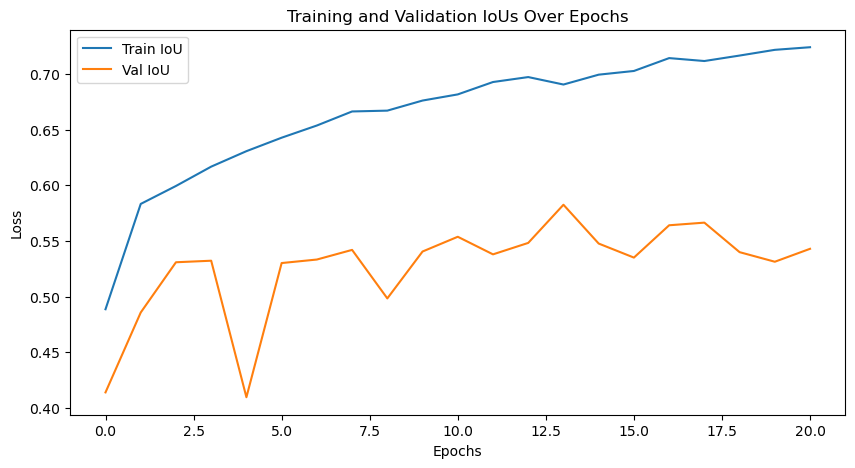

In [73]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_ious)), train_ious, label='Train IoU')
plt.plot(range(len(val_ious)), val_ious, label='Val IoU')

# Adding titles and labels
plt.title('Training and Validation IoUs Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

In [32]:
def plot_image_with_mask(img, mask, alpha=0.4):
    """
    Plots the image with an overlay of the mask in red, resizing the mask to match the image.

    Args:
    - img (str or numpy array): Path to the image file or image array.
    - mask (str or numpy array): Path to the mask file or mask array.
    - alpha (float): Transparency for overlaying mask.
    """

    # If img is a path, read the image file
    if isinstance(img, str):
        img = cv2.imread(img)

    # If mask is a path, read the mask file
    if isinstance(mask, str):
        mask = cv2.imread(mask)

    # Convert image from BGR to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize the mask to match the image size
    mask_resized = cv2.resize(mask, (img_rgb.shape[1], img_rgb.shape[0]))

    # Combine all three channels of the mask by taking the max value across channels
    mask = np.clip(np.max(mask_resized, axis=2), 0, 1)

    # Create a colored mask (Red where the mask is 1, transparent elsewhere)
    colored_mask = np.zeros_like(img_rgb)  # Same shape as img, but all zeros
    colored_mask[:, :, 0] = mask * 255  # Red channel gets the mask values

    # Overlay the red mask on the original image using alpha blending
    overlay_img = cv2.addWeighted(img_rgb, 1 - alpha, colored_mask, alpha, 0)

    # Plot the image with the red mask overlay
    plt.figure(figsize=(5, 5))
    plt.imshow(overlay_img)
    plt.title("Image with Red Mask Overlay")
    plt.axis('off')
    plt.show()

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    

In [33]:
masks = glob("../data/dataset/training_noisy_labels/*png")
images = [i.replace("training_noisy_labels", "training_patches") for i in masks]
len(images) , len(masks)

(5000, 5000)

In [34]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import cv2
import os
from torchvision import transforms
import numpy as np

class myInferDataset(Dataset):
    def __init__(self, images_list, masks_list, transform=False):
        self.transform = transform
        self.to_tensor = transforms.ToTensor()  # Transform to Tensor after augmentation
        self.images_list = images_list
        self.masks_list = masks_list

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        image_path = self.images_list[idx]
        mask_path = image_path.replace("training_patches", "training_noisy_labels")
        image_id = os.path.basename(image_path)  

        try:
            # Load image and mask using OpenCV
            image = cv2.imread(image_path)  # Read image (BGR format)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read mask as grayscale
            if image is None or mask is None:
                raise FileNotFoundError(f"File not found: {image_path} or {mask_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        except Exception as e:
            print(f"Error loading image or mask: {e}")
            # Return a dummy tensor if an error occurs
            image = np.zeros((256, 256, 3), dtype=np.uint8)
            mask = np.zeros((256, 256), dtype=np.uint8)

        if self.transform:
            # Convert both to tensors after augmentations
            image = self.to_tensor(image)  # Transforms automatically handles normalization
            mask = torch.as_tensor(mask, dtype=torch.float32).unsqueeze(0)  # Ensure mask is 1 channel

        else:
            # Normalize image manually and convert to PyTorch tensors without augmentations
            image = torch.as_tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0  # Normalize image to [0, 1]
            mask = torch.as_tensor(mask, dtype=torch.float32).unsqueeze(0)  # Single-channel mask

        return image,mask ,image_id
        
infer_dataset = myInferDataset(images , masks , transform=False)
infer_loader = DataLoader(infer_dataset , batch_size=1, shuffle=False)

In [51]:
model.eval();

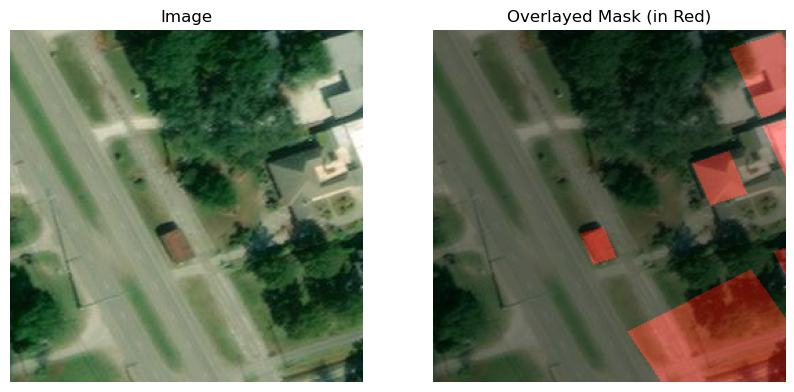

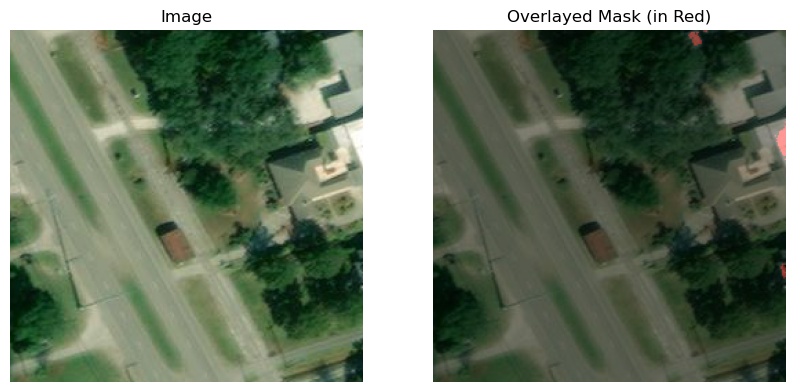

In [67]:
idx = 200
threshold=0.1
image_raw, mask, fn = infer_dataset[idx]
visualize_augmentation(image=image_raw, mask=mask)
image = image_raw.unsqueeze(0).to(device)
outputs = model(image)
pred_mask = (torch.sigmoid(outputs) > threshold).float()
pred_mask = pred_mask.squeeze(0)
binary_mask = pred_mask.cpu()  # Convert to numpy array
visualize_augmentation(image=image_raw, mask=binary_mask)

In [60]:
binary_mask.shape, mask.shape

((1, 256, 256), torch.Size([1, 256, 256]))

In [ ]:
pred_list = []
model.eval()  # Set the model to evaluation mode
results_list = []  # To store image and loss pairs
with torch.no_grad():  # Disable gradient computation
    for image, mask, image_id in tqdm(dataloader):
        output_path = out_dir+f'/{image_id[0]}'

        image = image.to(device)      # [batch_size, 3, 256, 256]
        mask = mask.to(device)        # [batch_size, 1, 256, 256]
        outputs = model(image)

        loss = criterion(outputs, mask).cpu().item()
        
        pred_mask = (torch.sigmoid(outputs) > threshold).float()  # Binary mask [1, 1, 256, 256]
        intersection = (pred_mask * mask).sum()
        union = pred_mask.sum() + mask.sum() - intersection
        iou = (intersection / (union + 1e-6)).cpu().numpy()  # Add small value to avoid division by zero

        pred_mask = pred_mask.squeeze(0).squeeze(0)
        binary_mask = pred_mask.cpu().numpy()  # Convert to numpy array
        binary_mask = (np.stack([binary_mask] * 3, axis=-1))          
        
        pred_list.append([image_id[0] ,iou,loss])
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        # Save the predicted mask
        cv2.imwrite(output_path, binary_mask)
return pred_list